## Isometric Mapping (Isomap)

Isomap is a special case of the generalized classical MDS, where instead of using Euclidean distances, the geodesic distance is used:

$
D_{ij}^{(g)} = \min \sum_{i=2}^{l} \| r_i - r_{i-1} \|_2,
$

where $( l \geq 2 )$ is the length of the sequence of points $ ( r_i \in \{x_i\}_{i=1}^l )$, and $( D_{ij}^{(g)} )$ denotes the geodesic distance matrix.

Isomap's formulation involves a kernel matrix based on the geodesic distance:

$
K = -\frac{1}{2} H D^{(g)} H
$

where $( D^{(g)} )$ is the geodesic distance matrix, and $( H )$ is the centering matrix.
Kernel Isomap extends the original by using kernel methods on the geodesic distance matrix:

$
K(D^2) = -\frac{1}{2} H D^2 H
$

And a modified kernel $( K' ) $ is defined as:

$
K' = K(D^2) + 2cK(D) + \frac{1}{c} H,
$

where $( c \geq c^* )$, and $( c^* )$ is the largest eigenvalue of the matrix:

$
\begin{bmatrix}
0 & 2K(D^2) \\
-4K(D^2) & 0
\end{bmatrix}.
$

For out-of-sample embedding, Isomap uses kernel mapping. Consider a mapping of any data point:

$
y(x) = \sum_{j=1}^{n} \alpha_j k(x, x_j),
$

where $( k(x, x_j) ) $ is a Gaussian kernel:

$
k(x, x_j) = \exp\left( -\frac{\| x - x_j \|^2}{2 \sigma_j^2} \right),
$

and $ ( \sigma_j )$ is defined as:

$
\sigma_j := \gamma \times \min_i \| x_j - x_i \|_2,
$

where $( \gamma )$ is a small positive number. The objective is to minimize the following cost function to obtain the out-of-sample points:

$
\text{minimize} \sum_{i=1}^{n} \| y_i - y(x_i) \|_2^2.
$

The corresponding kernel matrix is defined as:

$
K'(i,j) = \frac{k(x_i^{(t)}, x_j)}{\sum_{l=1}^{n} k(x_l^{(t)}, x_j)},
$

where $( x_i^{(t)} )$ is the $( i )th $ out-of-sample data point.


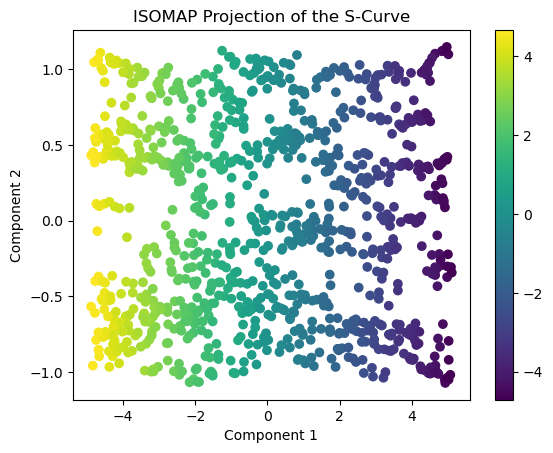

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.linalg import eigh
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

def isomap(data, n_neighbors=5, n_components=2):
    # Step 1: Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(data, data)

    # Step 2: Build the neighborhood graph
    n_samples = data.shape[0]
    neighborhood_graph = np.full((n_samples, n_samples), np.inf)

    # Connect each point to its k nearest neighbors
    for i in range(n_samples):
        nearest_neighbors = np.argsort(distances[i])[:n_neighbors + 1]  # +1 includes the point itself
        neighborhood_graph[i, nearest_neighbors] = distances[i, nearest_neighbors]

    # Step 3: Compute shortest paths (geodesic distances)
    geodesic_distances = shortest_path(neighborhood_graph, method='D', directed=False)

    # Step 4: Double-center the geodesic distance matrix
    n = geodesic_distances.shape[0]
    h = np.eye(n) - np.ones((n, n)) / n
    b = -0.5 * h @ (geodesic_distances ** 2) @ h

    # Step 5: Compute the top eigenvalues and eigenvectors
    eigvals, eigvecs = eigh(b, eigvals=(n - n_components, n - 1))  # Get largest n_components eigenvalues
    indices = np.argsort(eigvals)[::-1]  # Sort in descending order
    eigvals, eigvecs = eigvals[indices], eigvecs[:, indices]

    # Step 6: Compute the coordinates in the reduced space
    embedding = eigvecs * np.sqrt(eigvals)

    return embedding[:, :n_components]

# Generate the S-curve dataset
data, color = make_s_curve(n_samples=1000, noise=0.05)

# Apply ISOMAP
reduced_data = isomap(data, n_neighbors=10, n_components=2)

# Plot the result
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color, cmap='viridis')
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('ISOMAP Projection of the S-Curve')
plt.show()
